In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import manifold
from matplotlib import pyplot as plt

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
plt.rcParams['font.family'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline

In [2]:
%store -r samples_data
%store -r threshold
%store -r cluster_2nd
cluster = cluster_2nd

In [3]:
# 对于每个类别进行判别
samples_features = cluster.iloc[:, 2:]
datetime_features = cluster[("时间", 'Unnamed: 1_level_1')]  # 时间性质
source_features = samples_features[samples_features.columns[[x for x in range(0, 7)]]]  # 原料性质
produc_features = samples_features[samples_features.columns[[x for x in range(7, 10)]]]  # 产品性质
manule_features = samples_features[samples_features.columns[[x for x in range(14, samples_features.shape[1])]]]  # 操作属性

<AxesSubplot:xlabel='None-None', ylabel='None-None'>

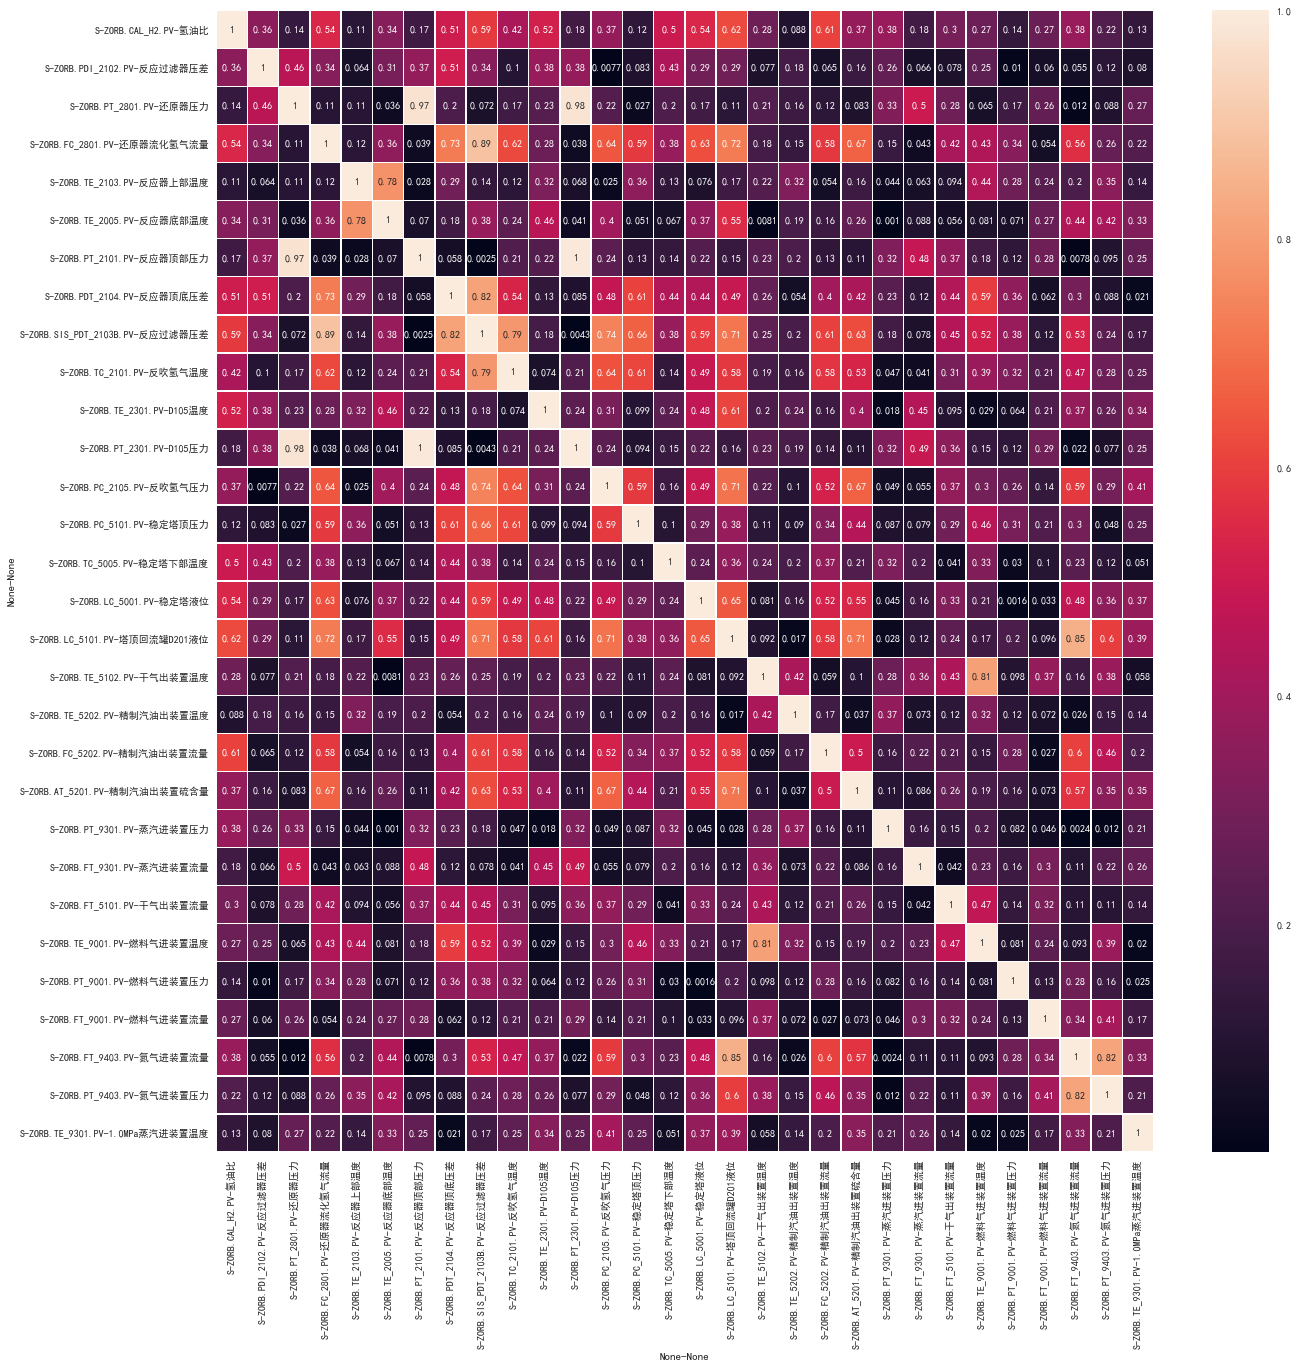

In [4]:
# 计算 操作属性 间的 相关系数 矩阵进行降维
manule_features_corr = manule_features.corr(method='spearman').abs()
# 展示 属性间 相关关系 热力图
fig, ax = plt.subplots(figsize=(21, 21))
sns.heatmap(manule_features_corr.iloc[:30, :30], annot=True, linewidths=.5, ax=ax)  # 只取出前 30 个属性作为一个例子

In [5]:
# Upper triangle of correlations
upper = manule_features_corr.where(np.triu(np.ones(manule_features_corr.shape), k=1).astype(np.bool))
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 317 columns to remove.


In [6]:
manule_features = manule_features.drop(columns = to_drop)
manule_features.head()

,S-ZORB.CAL_H2.PV,S-ZORB.PDI_2102.PV,S-ZORB.TE_2103.PV,S-ZORB.TE_5102.PV,S-ZORB.PT_9301.PV,S-ZORB.PT_9001.PV,S-ZORB.FT_9001.PV,S-ZORB.FT_9401.PV,S-ZORB.FC_1005.PV,S-ZORB.LC_1201.PV,S-ZORB.LC_1202.PV,S-ZORB.PC_2601.PV,S-ZORB.TC_2607.PV,S-ZORB.LI_9102.DACA,S-ZORB.LC_3301.DACA,S-ZORB.FT_3501.DACA,S-ZORB.PC_3001.DACA,cluster
,氢油比,反应过滤器压差,反应器上部温度,干气出装置温度,蒸汽进装置压力,燃料气进装置压力,燃料气进装置流量,净化风进装置流量,原料泵出口流量,D104液面,D121液面,再生器压力,再生器温度,D-204液位,D123冷凝水罐液位,循环氢至闭锁料斗料腿流量,D-113压力,
324,0.238883,18.426142,425.160278,32.827091,0.903980,0.469216,462.368250,101.248270,139.119180,50.034019,50.075354,0.110061,491.636880,49.473894,49.678956,0.060967,0.049977,2
323,0.235185,18.626541,426.057338,29.813634,0.891538,0.386031,434.992265,110.436909,139.402690,50.013484,50.016626,0.109911,501.057473,42.173350,50.000428,0.077354,0.049984,2
322,0.237478,18.477196,425.390800,30.861315,0.874332,0.394886,437.108447,104.572555,139.676740,50.051713,49.981726,0.110418,497.497753,45.007163,49.930400,-0.005746,0.049981,2
321,0.239947,18.356451,425.062968,30.267192,0.926917,0.396599,461.212157,111.859991,140.046538,50.011796,49.998568,0.109738,485.254352,66.449456,49.875656,0.160098,0.050049,2
320,0.238174,18.169647,424.567210,30.545865,0.902467,0.370835,448.172485,105.039895,139.772818,50.039356,50.023680,0.110002,489.138528,42.912789,50.088672,-0.017485,0.049979,2


In [7]:
print(source_features.reindex().shape)
print(produc_features.reindex().shape)
print(manule_features.reindex().shape)

(100, 7)
(100, 3)
(100, 18)


In [8]:
y = produc_features[('产品性质', 'RON损失\n（不是变量）')].to_numpy()
X = manule_features.to_numpy()

In [9]:
# Bootstrap Sampling
def bootstrap(data, size):
    return [random.choice(data) for _ in range(size)]

In [10]:
# 使用 T-SNE 进行数据降维
# X是特征，不包含target; X_tsne 是已经降维之后的特征
# 指定降维后的维数
relate_features = set()
max_iter = 60
num_iter = 0
features_pool = list(set(manule_features.keys().to_numpy()))

while len(relate_features) <= int(len(features_pool)/3) and num_iter <= max_iter:
    choice_features = bootstrap(features_pool, int(manule_features.shape[1]/2))
    re_dimension = int(len(list(set(choice_features)))/3)
    tsne = manifold.TSNE(n_components=re_dimension, perplexity=6, n_iter=6000, init='pca', method="exact")
    X_tsne = tsne.fit_transform(manule_features[list(set(choice_features))].to_numpy())
    print(f"num_iter => {num_iter} 原始样本数据维度 {len(list(set(choice_features)))}. t-SNE降维后的数据维度 {X_tsne.shape[-1]}")
    tSNE_features = pd.DataFrame(data=X_tsne, columns=[f'feature_{x + 1}' for x in range(re_dimension)])
    tSNE_features_full = tSNE_features.join(samples_data[[('产品性质', 'RON损失\n（不是变量）')]])
    tSNE_features_full_corr = tSNE_features_full.corr(method='spearman').abs().replace(1.0, np.nan)
    tSNE_feature = tSNE_features_full_corr[('产品性质', 'RON损失\n（不是变量）')].idxmax()
    combine_features = manule_features[features_pool].join(pd.DataFrame(data=tSNE_features[[tSNE_feature]].values, columns=[('t-SNE', 'max-relative')]))
    combine_features_corr = combine_features.corr(method='spearman').abs().replace(1.0, np.nan)
    choice_feature = combine_features_corr[('t-SNE', 'max-relative')].idxmax()
    relate_features.add(choice_feature)
    num_iter += 1

print(relate_features)

num_iter => 0 原始样本数据维度 6. t-SNE降维后的数据维度 2
num_iter => 1 原始样本数据维度 7. t-SNE降维后的数据维度 2
num_iter => 2 原始样本数据维度 6. t-SNE降维后的数据维度 2
num_iter => 3 原始样本数据维度 6. t-SNE降维后的数据维度 2
num_iter => 4 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 5 原始样本数据维度 6. t-SNE降维后的数据维度 2
num_iter => 6 原始样本数据维度 7. t-SNE降维后的数据维度 2
num_iter => 7 原始样本数据维度 7. t-SNE降维后的数据维度 2
num_iter => 8 原始样本数据维度 8. t-SNE降维后的数据维度 2
{('S-ZORB.FT_9001.PV', '燃料气进装置流量'), ('S-ZORB.LI_9102.DACA', 'D-204液位'), ('S-ZORB.PT_9001.PV', '燃料气进装置压力'), ('S-ZORB.CAL_H2.PV', '氢油比'), ('S-ZORB.FT_3501.DACA', '循环氢至闭锁料斗料腿流量'), ('S-ZORB.PC_3001.DACA', 'D-113压力'), ('S-ZORB.FC_1005.PV', '原料泵出口流量')}


In [11]:
# 增加题目要求的变量作为建模属性
model_features = manule_features[list(relate_features)].join(source_features[('原料性质', '辛烷值RON')])
model_features = model_features.join(datetime_features)
model_features.describe()

,S-ZORB.FT_9001.PV,S-ZORB.LI_9102.DACA,S-ZORB.PT_9001.PV,S-ZORB.CAL_H2.PV,S-ZORB.FT_3501.DACA,S-ZORB.PC_3001.DACA,S-ZORB.FC_1005.PV,原料性质,时间
,燃料气进装置流量,D-204液位,燃料气进装置压力,氢油比,循环氢至闭锁料斗料腿流量,D-113压力,原料泵出口流量,辛烷值RON,Unnamed: 1_level_1
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,468.984118,51.357805,0.403434,0.263575,0.056043,0.050003,138.338169,-0.154221,1.523839e+18
std,34.368611,15.699375,0.020996,0.024919,0.121272,0.000045,5.511504,0.387075,2.726991e+16
min,404.252175,12.730229,0.370835,0.229733,-0.170501,0.049932,99.598683,-1.278630,1.492416e+18
25%,446.037259,40.886516,0.390262,0.245035,-0.017966,0.049984,136.667352,-0.370934,1.501337e+18
50%,462.840210,51.816659,0.401987,0.253856,-0.006170,0.049999,139.547546,-0.144010,1.518898e+18
75%,489.408372,61.644919,0.411658,0.281040,0.088490,0.050013,140.667117,0.082915,1.544645e+18
max,544.838402,88.717561,0.469244,0.352849,0.609803,0.050298,149.772425,0.763687,1.583482e+18


In [12]:
weight_2nd = manule_features.shape[0]/samples_features.shape[0]
model_features_2nd = model_features
produc_features_2nd = produc_features
%store model_features_2nd
%store produc_features_2nd
%store weight_2nd

Stored 'model_features_2nd' (DataFrame)
Stored 'produc_features_2nd' (DataFrame)
Stored 'weight_2nd' (float)
